# Get individual leaves

Now that we have individual pots, we need to identify individual leaves

**Currently stuck at trying to get _every_ leaf tip, to then run a watershed segmentation**

In [1]:
import tifffile as tf
import numpy as np
import pandas as pd

import glob
import numpy.polynomial.polynomial as P
from scipy import spatial
from scipy import interpolate
from scipy import ndimage

from sklearn import neighbors
from importlib import reload

import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import arabidopsis_utils as thales
import MinimumBoundingBox as mbb

from skimage.segmentation import watershed
from skimage.feature import peak_local_max

In [2]:
reload(thales)

<module 'arabidopsis_utils' from '/home/ejam/documents/arabidopsis_scanning/jupyter/arabidopsis_utils.py'>

In [3]:
tiff_file = '../raw3d/Day6_110821_U112-3.tif'
tiff_file = '../raw3d/Day7_110921_U112-3.tif'
tiff_file = '../raw3d/Day7_110921_Col_0_X.tif'
pot_src = '../pots/'

_, fname = os.path.split(tiff_file)
bname = os.path.splitext(fname)[0]

src = pot_src + bname + '/'

In [4]:
potfiles = sorted(glob.glob(src + bname + '_pot*.tif'))
potfiles

['../pots/Day7_110921_Col_0_X/Day7_110921_Col_0_X_pot0.tif',
 '../pots/Day7_110921_Col_0_X/Day7_110921_Col_0_X_pot1.tif',
 '../pots/Day7_110921_Col_0_X/Day7_110921_Col_0_X_pot2.tif',
 '../pots/Day7_110921_Col_0_X/Day7_110921_Col_0_X_pot3.tif']

In [5]:
pot = [None for i in range(len(potfiles))]

for i in range(len(pot)):
    foo = tf.imread(potfiles[i])
    pot[i]  = foo
#    print(np.sum(pot[i] > 0))

In [6]:
pidx = 2
pname = 'pot{}'.format(pidx)
img = pot[pidx].copy()
img[img < 50] = 0
img, ceros, cerosshape = thales.clean_zeroes(img)

print(np.max(img))

leaf_dst = '../leaves/'
dst = leaf_dst + bname + '/' + pname + '/'
if not os.path.isdir(dst):
    os.makedirs(dst)
print('All results will be saved in ', dst)

80 % reduction from input
255
All results will be saved in  ../leaves/Day7_110921_Col_0_X/pot2/


In [7]:
foo = thales.get_largest_element(img)
img = foo*img

62522 components
[69700590     1937     1098      999      651      610      519      506
      501      500      499      445      437      436      433      390
      354      350      349      347]


[(inf, None, 50), (453134, 251, 254), (420556, 82, 139), (19351, 140, 141), (16942, 136, 135), (14458, 143, 144), (13874, 132, 131), (12430, 129, 128), (9740, 125, 124), (9279, 147, 148), (8332, 86, 85), (8028, 78, 79), (7869, 118, 117), (7788, 122, 121), (7043, 89, 88), (6043, 96, 95), (5700, 75, 76), (5266, 93, 92), (4979, 104, 103), (4691, 100, 99), (4561, 111, 110), (4173, 107, 106), (3726, 150, 151), (2795, 71, 72), (2689, 114, 113), (1428, 154, 155), (241, 253, 252), (69, 241, 242), (39, 248, 249), (27, 244, 245), (22, 231, 232)]
113


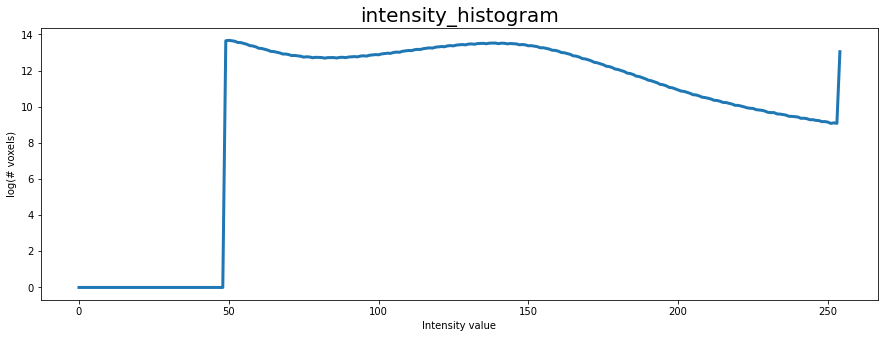

In [8]:
#foo = timg.copy()
thr = thales.get_individual_threshold(img, True)
print(thr)

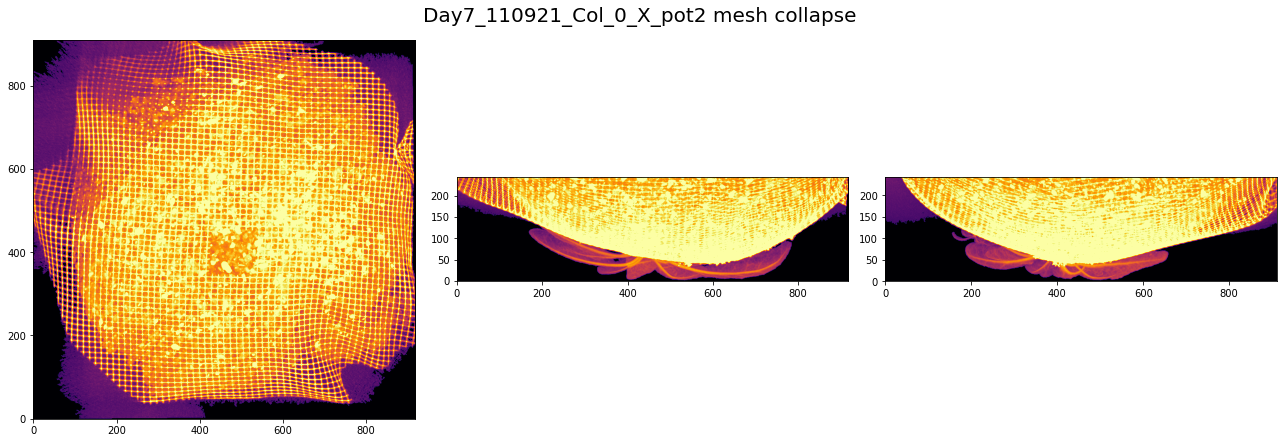

In [9]:
writefig = False
display  = True
diag_dst = src
snaps = thales.collapse_dimensions_max(img)
title = bname + '_' + pname
thales.plot_collapse_dimensions(snaps, title, 'mesh', display=display, writefig=True, dst=dst);

In [10]:
timg = img.copy()
timg[timg < 215] = 0

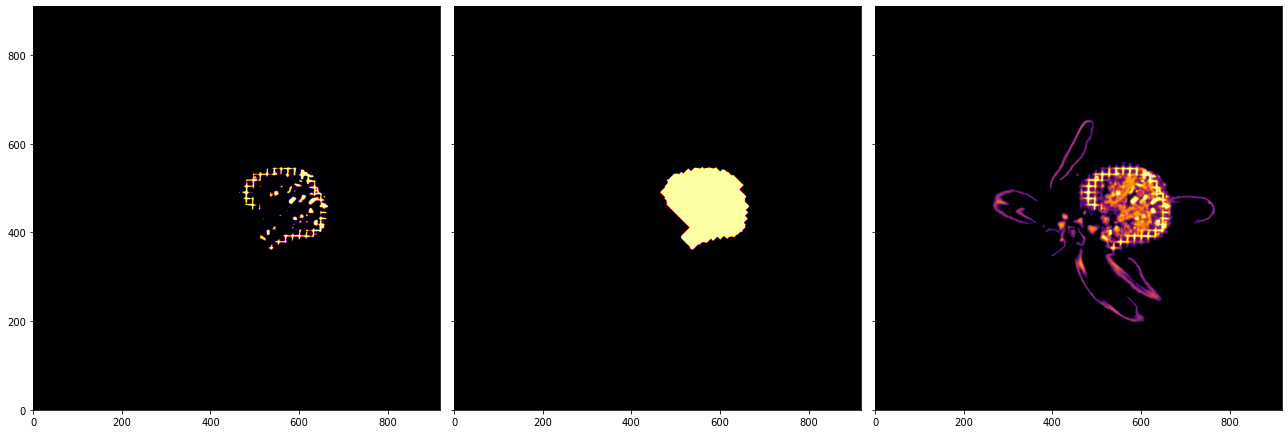

In [11]:
ss = np.s_[50,:, :]
iters = 60

fill = ndimage.binary_dilation(timg[ss], iterations=iters)
fill = ndimage.binary_dilation(fill, iterations=8, border_value=0)
fill = ndimage.binary_erosion(fill, iterations=8, border_value=1)

fill = ndimage.binary_fill_holes(fill)
#fill = ndimage.binary_closing(fill, iterations=4)
fill = ndimage.binary_erosion(fill, iterations=iters, border_value=1)
#fill = ndimage.binary_opening(fill, iterations=iters)

fig, ax = plt.subplots(1, 3, figsize=(18,8), sharex=True, sharey=True)

ax[0].imshow(timg[ss], cmap='inferno', origin='lower');
ax[1].imshow(fill, cmap='inferno', origin='lower');
ax[2].imshow(img[ss], cmap='inferno', origin='lower');

fig.tight_layout();

In [12]:
iters = 50
soil = np.zeros_like(img)

for i in range(img.shape[0]):
    ss = np.s_[i, :, :]
    fill = ndimage.binary_dilation(timg[ss], iterations=iters)
    
    fill = ndimage.binary_dilation(fill, iterations=8, border_value=0)
    fill = ndimage.binary_erosion(fill, iterations=8, border_value=1)

    fill = ndimage.binary_fill_holes(fill)
    ndimage.binary_erosion(fill, iterations=iters, output=soil[ss], border_value=1)

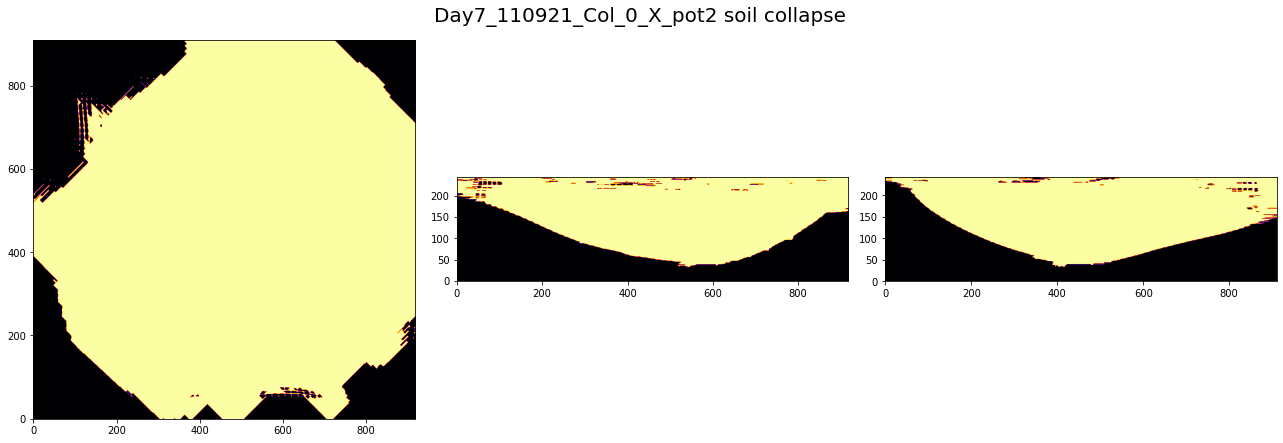

In [13]:
snaps = thales.collapse_dimensions_max(soil)
thales.plot_collapse_dimensions(snaps, title, 'soil', display=display, writefig=False, dst=diag_dst);

In [14]:
its = 2
struc = ndimage.generate_binary_structure(timg.ndim, timg.ndim)

#dsoil = ndimage.binary_erosion(soil, struc, iterations=its, border_value=1)
dsoil = ndimage.binary_dilation(soil, struc, iterations=2*its, border_value=0)

In [27]:
plant = ~dsoil*img.copy()
#plant[plant > 200] = 0
plant[plant < 65] = 0

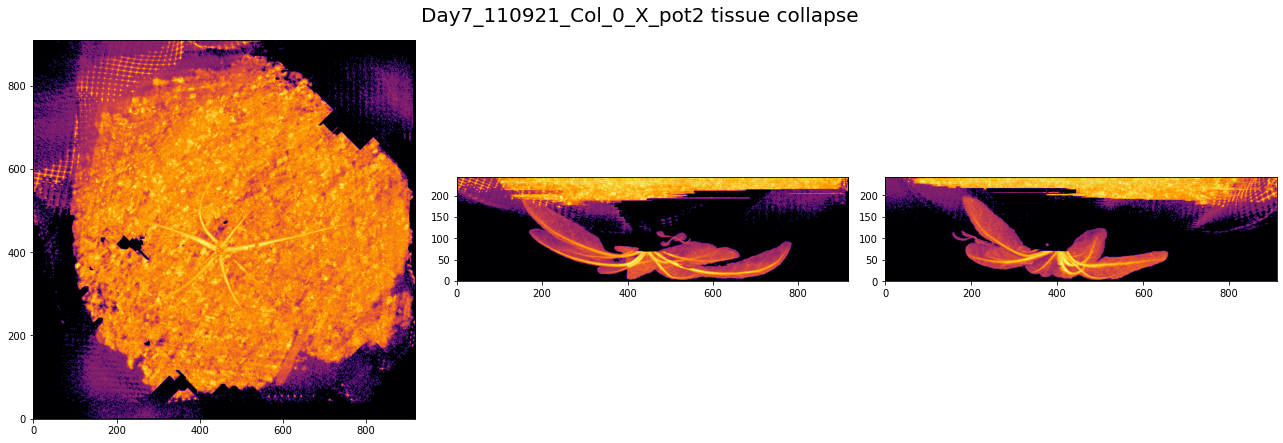

In [28]:
snaps = thales.collapse_dimensions_max(plant)
thales.plot_collapse_dimensions(snaps, title);

# Separate connected components

Find where the soil ends.

- Count the number of nonzero voxels per slice.
- We should see a drop past the soil level.

Find separate connected components after removing all the soil-related layers

In [29]:
labels,num = ndimage.label(plant, structure=ndimage.generate_binary_structure(plant.ndim, 1))
hist,bins = np.histogram(labels, bins=num, range=(1,num+1))
argsort_hist = np.argsort(hist)[::-1]
print(num, hist[argsort_hist][:20])

47786 [12146708   711750    49939    23669     4882     3906     2081     1275
     1088     1029     1025      942      906      837      831      770
      699      696      627      595]


In [30]:
cutoff = 1e-3
sz_hist = np.sum(hist)

foo = np.asarray(np.nonzero(hist/sz_hist > cutoff)).squeeze()
bar = np.argsort(hist[foo])[::-1]

signif_idx = foo[bar]
print('Large components: ', len(signif_idx))

Large components:  4


In [31]:
Comps = [None for x in range(len(signif_idx))]

for i in range(len(signif_idx)):
    idx = signif_idx[i]
    mask = labels==idx+1
    box = plant.copy()
    box[~mask] = 0

    snaps = thales.collapse_dimensions_max(box)
    Comps[i] = snaps

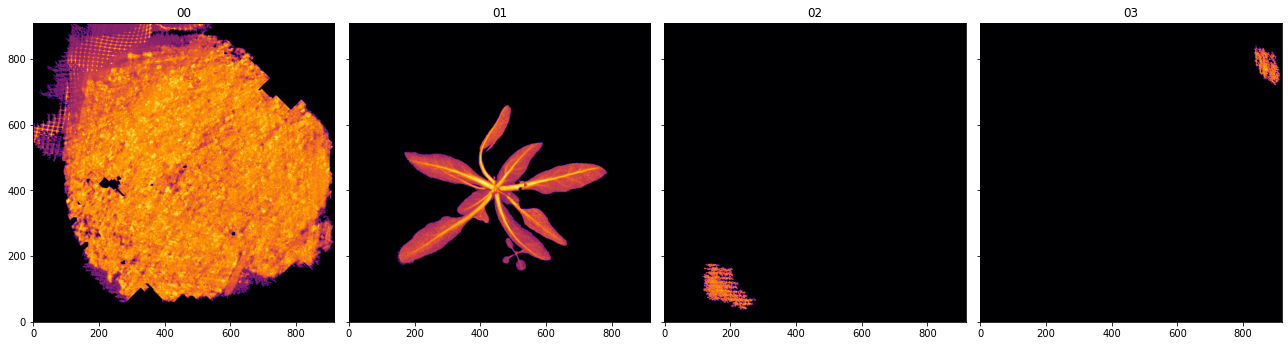

In [32]:
fig, ax = plt.subplots(1,4, figsize=(18,12), sharex=True, sharey=True)

for i,a in enumerate(ax.ravel()):
    a.imshow(Comps[i][0], origin='lower', cmap='inferno')
    a.set_title('{:02d}'.format(i))

fig.tight_layout();

In [34]:
means = ndimage.mean(plant, labels, index = signif_idx+1)
#mins = ndimage.minimum(plant, labels, index = signif_idx+1)
#maxs = ndimage.maximum(plant, labels, index = signif_idx+1)
medians = ndimage.median(plant, labels, index = signif_idx+1)

for i in range(len(signif_idx)):
    idx = signif_idx[i]
    print(i, idx, np.around(100*hist[idx]/sz_hist, 3),
          np.around([means[i], medians[i]], 2),
          sep='\t')

0	171	92.174	[118.27 121.  ]
1	0	5.401	[99.5 94. ]
2	8069	0.379	[70.12 69.  ]
3	12602	0.18	[70.46 69.  ]


In [35]:
arab = np.zeros_like(img)

for i in range(len(signif_idx)):
    idx = signif_idx[i]
    if (medians[i] > 85) and (medians[i] < 100) :
        mask = labels==idx+1
        box = plant.copy()
        box[~mask] = 0
        arab += box

        print(i, idx, np.around(100*hist[idx]/sz_hist, 3),
              np.around([mins[i], means[i], medians[i], maxs[i], maxs[i]-mins[i]], 2),
              sep='\t')

1	0	5.401	[ 60.   99.5  94.  213.  153. ]


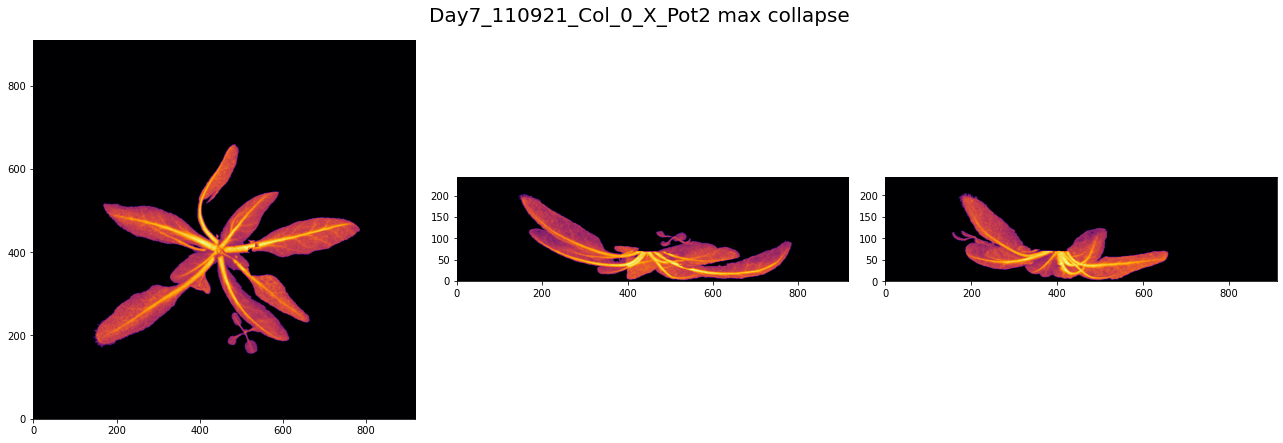

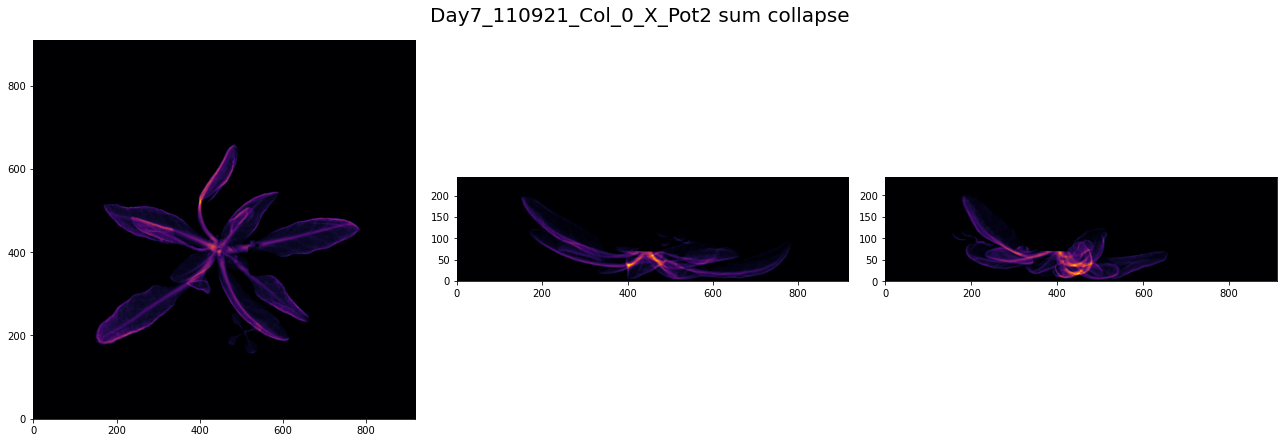

In [36]:
writefig = True
title = bname + '_Pot' + str(pidx)

snaps = thales.collapse_dimensions_max(arab)
thales.plot_collapse_dimensions(snaps, title, 'max', display=display, writefig=writefig, dst=dst);

snaps = thales.collapse_dimensions(arab)
thales.plot_collapse_dimensions(snaps, title, 'sum', display=display, writefig=writefig, dst=dst);

In [37]:
filename = dst + bname + '_pot{}_clean.tif'.format(pidx) 
tf.imwrite(filename, arab, photometric='minisblack',compress=3)